In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [2]:
from tensorflow.keras.preprocessing import image
from matplotlib.pyplot import imshow
import math
import numpy as np
from glob import glob

In [35]:
learning_rate = 0.0005
weight_decay = 0.00001
batch_size = 128
num_epochs = 10
image_size = 96  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [ # 인코딩 블락에서의 MLP 생성을 위한 값들
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 4
mlp_head_units = [1024, 512]  # Size of the dense layers of the final classifier

In [5]:
images = [image.load_img(p, target_size=(image_size, image_size))
          for p in glob('cats_dogs/cats/*jpg') + glob('cats_dogs/dogs/*jpg')]
vector = np.asarray([image.img_to_array(img) for img in images])

In [6]:
vector.shape

(2000, 96, 96, 3)

In [7]:
import matplotlib.pyplot as plt

In [8]:
vector[0]

array([[[ 40.,  45.,  41.],
        [ 41.,  45.,  48.],
        [ 40.,  43.,  50.],
        ...,
        [ 92.,  96.,  97.],
        [187., 185., 164.],
        [199., 196., 161.]],

       [[ 37.,  42.,  38.],
        [ 33.,  37.,  40.],
        [ 35.,  38.,  45.],
        ...,
        [100., 103., 108.],
        [180., 177., 160.],
        [201., 196., 166.]],

       [[ 41.,  46.,  42.],
        [ 34.,  38.,  41.],
        [ 37.,  40.,  47.],
        ...,
        [ 86.,  89.,  96.],
        [180., 174., 160.],
        [207., 197., 170.]],

       ...,

       [[ 22.,  20.,  21.],
        [ 21.,  19.,  20.],
        [ 21.,  19.,  20.],
        ...,
        [114.,  96.,  94.],
        [ 91.,  76.,  73.],
        [ 57.,  43.,  40.]],

       [[ 24.,  22.,  23.],
        [ 19.,  17.,  18.],
        [ 21.,  19.,  20.],
        ...,
        [ 70.,  52.,  48.],
        [ 50.,  35.,  30.],
        [ 40.,  27.,  21.]],

       [[ 30.,  28.,  29.],
        [ 21.,  19.,  20.],
        [ 25.,  

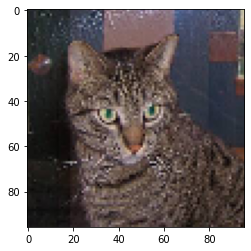

In [9]:
plt.imshow(vector[0]/255)
plt.show()

In [13]:
num_classes = 2
input_shape = (image_size, image_size, 3)

In [14]:
labels = [1] * 1000 + [0] * 1000

In [15]:
labels = np.array(labels)

In [16]:
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test = train_test_split(vector, labels, test_size=0.2)

In [36]:
# data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [37]:
# position-wise FFN
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [38]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 96 X 96
Patch size: 6 X 6
Patches per image: 256
Elements per patch: 108


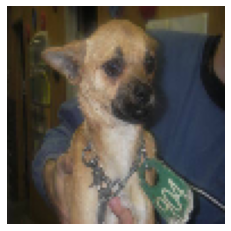

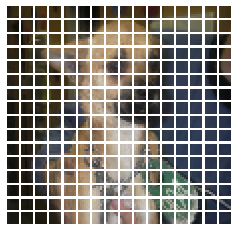

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [40]:
class PatchEncoder(layers.Layer):
    """
    The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.
    """
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [41]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    print(augmented.shape)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [47]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
#             keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./checkpoints"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        mode='min',
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

In [48]:
vit_classifier = create_vit_classifier()

(None, 96, 96, 3)


In [49]:
vit_classifier.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 96, 96, 3)   7           ['input_4[0][0]']                
                                                                                                  
 patches_5 (Patches)            (None, None, 108)    0           ['data_augmentation[1][0]']      
                                                                                                  
 patch_encoder_3 (PatchEncoder)  (None, 256, 64)     23360       ['patches_5[0][0]']              
                                                                                            

 multi_head_attention_15 (Multi  (None, 256, 64)     66368       ['layer_normalization_33[0][0]', 
 HeadAttention)                                                   'layer_normalization_33[0][0]'] 
                                                                                                  
 add_30 (Add)                   (None, 256, 64)      0           ['multi_head_attention_15[0][0]',
                                                                  'add_29[0][0]']                 
                                                                                                  
 layer_normalization_34 (LayerN  (None, 256, 64)     128         ['add_30[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 dense_43 (Dense)               (None, 256, 128)     8320        ['layer_normalization_34[0][0]'] 
          

In [50]:
history = run_experiment(vit_classifier)

Epoch 1/10
12/12 [==============================] - 55s 4s/step - loss: 1.9690 - accuracy: 0.5278 - val_loss: 0.9314 - val_accuracy: 0.5938
Epoch 2/10
12/12 [==============================] - 50s 4s/step - loss: 1.6842 - accuracy: 0.5368 - val_loss: 0.7568 - val_accuracy: 0.6438
Epoch 3/10
12/12 [==============================] - 50s 4s/step - loss: 1.3155 - accuracy: 0.5417 - val_loss: 0.7428 - val_accuracy: 0.5437
Epoch 4/10
12/12 [==============================] - 51s 4s/step - loss: 1.0800 - accuracy: 0.5229 - val_loss: 0.7135 - val_accuracy: 0.5437
Epoch 5/10
12/12 [==============================] - 50s 4s/step - loss: 0.9199 - accuracy: 0.5500 - val_loss: 0.6807 - val_accuracy: 0.5875
Epoch 6/10
12/12 [==============================] - 50s 4s/step - loss: 0.8705 - accuracy: 0.5694 - val_loss: 0.6586 - val_accuracy: 0.5938
Epoch 7/10
12/12 [==============================] - 48s 4s/step - loss: 0.8083 - accuracy: 0.5618 - val_loss: 0.6930 - val_accuracy: 0.5125
Epoch 8/10
12/12 [==